In [1]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [4]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


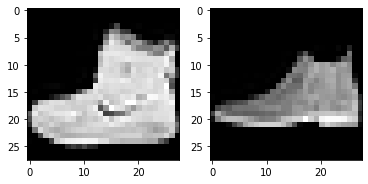

In [5]:
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')

plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')

In [6]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [7]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [8]:
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=42)

In [9]:
## Basic Parameters

batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28

In [10]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [11]:
input_img = Input(shape = (x, y, inChannel))
autoencoder = Model(input_img, autoencoder(input_img))

In [12]:
autoencoder.compile(loss='mse', optimizer = 'adam',metrics=['mae'])

In [13]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [14]:
history = autoencoder.fit(train_X, train_ground, 
                                    batch_size=batch_size,epochs=epochs,verbose=1,
                                    validation_data=(valid_X, valid_ground))

Epoch 1/50
375/375 [==============================] - 3s 7ms/step - loss: 0.0174 - mae: 0.0705 - val_loss: 0.0107 - val_mae: 0.0552
Epoch 2/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0070 - mae: 0.0423 - val_loss: 0.0059 - val_mae: 0.0387
Epoch 3/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0052 - mae: 0.0360 - val_loss: 0.0046 - val_mae: 0.0335
Epoch 4/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0043 - mae: 0.0327 - val_loss: 0.0040 - val_mae: 0.0311
Epoch 5/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0038 - mae: 0.0307 - val_loss: 0.0036 - val_mae: 0.0293
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0034 - mae: 0.0292 - val_loss: 0.0034 - val_mae: 0.0292
Epoch 7/50
375/375 [==============================] - 2s 6ms/step - loss: 0.0032 - mae: 0.0279 - val_loss: 0.0031 - val_mae: 0.0276
Epoch 8/50
375/375 [==============================] - 2s 6ms/step - loss: 0.

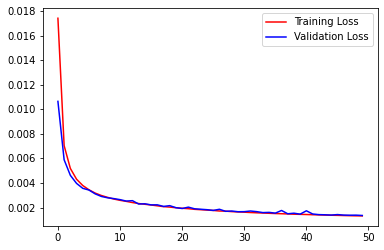

In [15]:
plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

In [17]:
reconstructed = autoencoder.predict(test_data)

In [18]:
reconstructed.shape

(10000, 28, 28, 1)

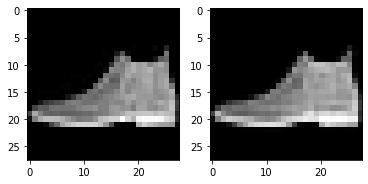

In [21]:
plt.subplot(121)
curr_img = np.reshape(test_data[0], (28,28))
# curr_lbl = test_label[0]
plt.imshow(curr_img, cmap='gray')

plt.subplot(122)
curr_img = np.reshape(reconstructed[0], (28,28))
# curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')